In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
%matplotlib inline

In [13]:
# File DEBIT_Canton.csv einlesen
url = "https://drive.switch.ch/index.php/s/PSg7Y8Za5LmQ5dn/download?path=%2F&files=DEBIT_Canton.csv"
raw_data = pd.read_csv(url)
raw_data.head(3)

,Unnamed: 0,FINALPROCESSINGDATE,TYPE,KANTON,GROSSREGION,COUNTRY,NTRX,ISSUINGBASEAMOUNT,ATV
0,0,01-APR-19,ATM,99,99.0,AUT,2044,412477,201.80
1,1,01-APR-19,ATM,99,99.0,CHE,433,285450,659.24
2,2,01-APR-19,ATM,99,99.0,DEU,6239,1206750,193.42


In [14]:
len(raw_data)


43362

In [4]:
raw_data.dtypes

Unnamed: 0               int64
FINALPROCESSINGDATE     object
TYPE                    object
KANTON                  object
GROSSREGION            float64
COUNTRY                 object
NTRX                     int64
ISSUINGBASEAMOUNT        int64
ATV                    float64
dtype: object

In [15]:
raw_data.columns

Index(['Unnamed: 0', 'FINALPROCESSINGDATE', 'TYPE', 'KANTON', 'GROSSREGION',
       'COUNTRY', 'NTRX', 'ISSUINGBASEAMOUNT', 'ATV'],
      dtype='object')

In [16]:
# raw_data bereinigen
data = raw_data.drop(columns=["Unnamed: 0", "COUNTRY", "GROSSREGION"])
data_sh = data.loc[data["KANTON"] == "SH", ["FINALPROCESSINGDATE", "TYPE", "NTRX", "ISSUINGBASEAMOUNT", "ATV"]].sort_index()
data_sh.head(3)

,FINALPROCESSINGDATE,TYPE,NTRX,ISSUINGBASEAMOUNT,ATV
23,01-APR-19,ATM,1988,664240,334.12
56,01-APR-19,POS,16044,715445,44.59
89,01-APR-20,ATM,1964,954164,485.83


In [17]:
# data_sh aufsplitten

data_ATM = data_sh.loc[data_sh["TYPE"] == "ATM", ["FINALPROCESSINGDATE", "NTRX", "ISSUINGBASEAMOUNT", "ATV"]].sort_index()
data_POS = data_sh.loc[data_sh["TYPE"] == "POS", ["FINALPROCESSINGDATE", "NTRX", "ISSUINGBASEAMOUNT", "ATV"]].sort_index()
data_POS

,FINALPROCESSINGDATE,NTRX,ISSUINGBASEAMOUNT,ATV
56,01-APR-19,16044,715445,44.59
122,01-APR-20,15984,677369,42.38
188,01-AUG-19,6925,298134,43.05
254,01-AUG-20,10888,436364,40.08
320,01-DEC-19,5208,219331,42.11
...,...,...,...,...
43088,31-MAR-19,5651,194571,34.43
43154,31-MAR-20,15766,667701,42.35
43220,31-MAY-19,20137,1110067,55.13
43286,31-MAY-20,7818,264469,33.83


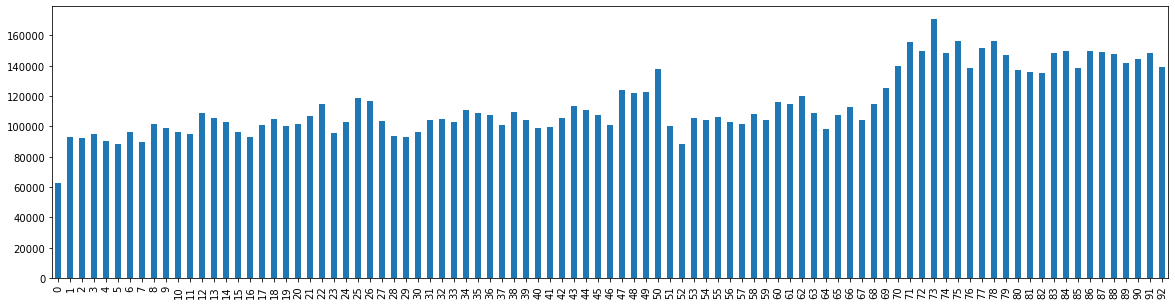

In [8]:
# Datum POS konvertieren

pos_data_date_str = []
for pos_string in data_POS["FINALPROCESSINGDATE"]:
    pos_s = str(pos_string)
    pos_data_date_str.append(pos_s)
pos_data_date_str

# Datum POS konvertieren in datetime

pos_clean_date1 = []
for pos_date in pos_data_date_str:
    pos_d = datetime.strptime(pos_date, '%d-%b-%y')
    pos_clean_date1.append(pos_d)

# Datum POS kürzen

pos_clean_date = []
for pos_short in pos_clean_date1:
    pos_e = pos_short.strftime("%Y-%m-%d")
    pos_clean_date.append(pos_e)

# Datum POS hinzufügen

data_POS["Datum"] = pos_clean_date

# Dataframe finalisieren

pos_final = data_POS[["Datum", "NTRX", "ISSUINGBASEAMOUNT", "ATV"]]
pos_final = pos_final.sort_values("Datum").rename(columns={"NTRX" : "Anzahl"}).rename(columns={"ISSUINGBASEAMOUNT" : "Total"}).rename(columns={"ATV" : "Durchschnitt"})
pos_final = pos_final.reset_index()
pos_final = pos_final.drop(columns=["index"]) 

# pos_final.to_csv('pos.csv')

# Kalenderwoche herausfinden

pos_kw = []
for pos_tag_string in pos_final["Datum"]:
  pos_wochentag = datetime.strptime(pos_tag_string, '%Y-%m-%d')
  pos_kw.append(datetime.date(pos_wochentag).isocalendar()[:-1])

# Kalenderwoche hinzufügen
pos_final["Kalenderwoche"] = pos_kw 

# Umwandeln in Pivot-Tabelle

pos_final_dev = pos_final.pivot_table(index="Datum", columns="Kalenderwoche", values="Anzahl", aggfunc = "sum", margins=True).fillna('')
pos_final_dev_short = pos_final_dev.tail(1)
pos_final_dev_short

# Rückumwandlung

pos_melted = pd.melt(pos_final_dev_short).head(93)

# Plot POS
pos_melted['value'].plot(kind='bar', figsize=(20,5))

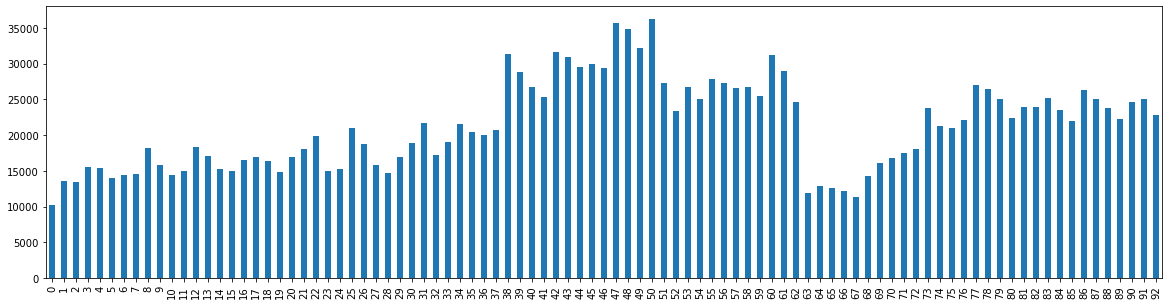

In [9]:
# Datum ATM konvertieren

atm_data_date_str = []
for atm_string in data_ATM["FINALPROCESSINGDATE"]:
    atm_s = str(atm_string)
    atm_data_date_str.append(atm_s)
atm_data_date_str

# Datum ATM konvertieren in datetime

atm_clean_date1 = []
for atm_date in atm_data_date_str:
    atm_d = datetime.strptime(atm_date, '%d-%b-%y')
    atm_clean_date1.append(atm_d)

# Datum ATM kürzen

atm_clean_date = []
for atm_short in atm_clean_date1:
    atm_e = atm_short.strftime("%Y-%m-%d")
    atm_clean_date.append(atm_e)

# Datum ATM hinzufügen

data_ATM["Datum"] = atm_clean_date

# Dataframe finalisieren

atm_final = data_ATM[["Datum", "NTRX", "ISSUINGBASEAMOUNT", "ATV"]]
atm_final = atm_final.sort_values("Datum").rename(columns={"NTRX" : "Anzahl"}).rename(columns={"ISSUINGBASEAMOUNT" : "Total"}).rename(columns={"ATV" : "Durchschnitt"})
atm_final = atm_final.reset_index()
atm_final = atm_final.drop(columns=["index"]) 

# atm_final.to_csv('atm.csv')
# pos_final.to_csv('pos.csv')

# Kalenderwoche herausfinden

atm_kw = []
for atm_tag_string in atm_final["Datum"]:
  atm_wochentag = datetime.strptime(atm_tag_string, '%Y-%m-%d')
  atm_kw.append(datetime.date(atm_wochentag).isocalendar()[:-1])

# Kalenderwoche hinzufügen
atm_final["Kalenderwoche"] = atm_kw 

# Umwandeln in Pivot-Tabelle

atm_final_dev = atm_final.pivot_table(index="Datum", columns="Kalenderwoche", values="Anzahl", aggfunc = "sum", margins=True).fillna('')
atm_final_dev_short = atm_final_dev.tail(1)
atm_final_dev_short

# Rückumwandlung

atm_melted = pd.melt(atm_final_dev_short).head(93)

# Plot ATM
atm_melted['value'].plot(kind='bar', figsize=(20,5))

In [10]:
# Diagramm kürzen

pos_2020 = pos_melted.iloc[52:]
atm_2020 = atm_melted.iloc[52:]


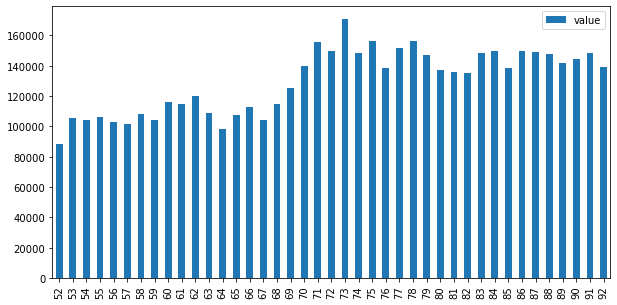

In [11]:
pos_2020.reset_index()
pos_2020.plot(kind='bar', figsize=(10,5))

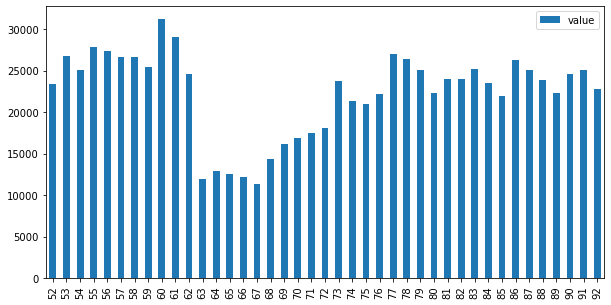

In [12]:
atm_2020.plot(kind='bar', figsize=(10,5))

In [18]:
data_POS.head()

,FINALPROCESSINGDATE,NTRX,ISSUINGBASEAMOUNT,ATV
56,01-APR-19,16044,715445,44.59
122,01-APR-20,15984,677369,42.38
188,01-AUG-19,6925,298134,43.05
254,01-AUG-20,10888,436364,40.08
320,01-DEC-19,5208,219331,42.11


In [49]:
data_POS.dtypes

FINALPROCESSINGDATE     object
NTRX                     int64
ISSUINGBASEAMOUNT        int64
ATV                    float64
dtype: object

In [51]:
raw_data["FINALPROCESSINGDATE"] = pd.to_datetime(raw_data["FINALPROCESSINGDATE"], format="%d-%b-%y")

In [52]:
raw_data["FINALPROCESSINGDATE"]

0       2019-04-01
1       2019-04-01
2       2019-04-01
3       2019-04-01
4       2019-04-01
           ...    
43357   2019-10-31
43358   2019-10-31
43359   2019-10-31
43360   2019-10-31
43361   2019-10-31
Name: FINALPROCESSINGDATE, Length: 43362, dtype: datetime64[ns]

In [19]:
data_POS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 657 entries, 56 to 43352
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FINALPROCESSINGDATE  657 non-null    object 
 1   NTRX                 657 non-null    int64  
 2   ISSUINGBASEAMOUNT    657 non-null    int64  
 3   ATV                  657 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 25.7+ KB


In [20]:
pd.to_datetime("01-APR-19", format='%d-%b-%y', errors='ignore')

Timestamp('2019-04-01 00:00:00')

In [22]:
#https://strftime.org/

In [23]:
data_POS[''] = pd.to_datetime(data_POS['FINALPROCESSINGDATE'], format='%d-%b-%y', errors='ignore')

In [25]:
data_POS.index = data_POS['Date']

In [41]:
data_POS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657 entries, 2019-04-01 to 2019-10-31
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   FINALPROCESSINGDATE  657 non-null    object        
 1   NTRX                 657 non-null    int64         
 2   ISSUINGBASEAMOUNT    657 non-null    int64         
 3   ATV                  657 non-null    float64       
 4   Date                 657 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 50.8+ KB


In [45]:
data_POS.sort_values(by='Date')

ValueError: 'Date' is both an index level and a column label, which is ambiguous.